In [1]:
# the first time to integrate the large iteration process
# rewrite the small iteration process as a function
# 33-bus的配网数据，用直流潮流进行说明
# 2023.0915更新，负荷平均分配给33节点
# 光伏的可选位置包括5个不同的节点
# 负荷数据采用bench的4典型场景
# 修改网络线路参数-9-10节点,传送能力有限

In [2]:
import time
import numpy as np
import math
import cvxpy as cvx
import pandas as pd
import matplotlib.pyplot as plt
import gurobipy
# cluster the load into different groups
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn import manifold
from sklearn.metrics.pairwise import pairwise_distances

In [3]:
# df_pv_original = pd.read_csv("data/day_PV_original.csv", header=None)
# pv_original = df_pv_original.values
# pv_max_value = np.max(pv_original)
# pv_data = pv_original/pv_max_value
# pv_data_save = pd.DataFrame(pv_data)
# pv_data_save.to_csv('data/day_pv.csv', sep= ',', encoding='utf-8', header=False, index=False)

In [4]:
import os
os.environ['LD_LIBRARY_PATH'] += '/home/hmy/matlabrt/v912/runtime/glnxa64:/home/hmy/matlabrt/v912/bin/glnxa64:/home/hmy/matlabrt/v912/sys/os/glnxa64:/home/hmy/matlabrt/v912/extern/bin/glnxa64'
import f_find_nadir
find_nadir = f_find_nadir.initialize()

警告: 名称不存在或不是目录: /home/hmy/SMR-Revise-0914/network/C
> 位置：path (第 109 行)
位置: addpath (第 84 行)
位置: startup (第 4 行)
警告: 名称不存在或不是目录: /home/hmy/SMR-Revise-0914/network/\Research Documents\MATLAB Documents\matpower7.1\matpower7.1\lib
> 位置：path (第 109 行)
位置: addpath (第 84 行)
位置: startup (第 4 行)
警告: 名称不存在或不是目录: /home/hmy/SMR-Revise-0914/network/C
> 位置：path (第 109 行)
位置: addpath (第 84 行)
位置: startup (第 4 行)
警告: 名称不存在或不是目录: /home/hmy/SMR-Revise-0914/network/\Research Documents\MATLAB Documents\matpower7.1\matpower7.1\lib\t
> 位置：path (第 109 行)
位置: addpath (第 84 行)
位置: startup (第 4 行)
警告: 名称不存在或不是目录: /home/hmy/SMR-Revise-0914/network/C
> 位置：path (第 109 行)
位置: addpath (第 84 行)
位置: startup (第 4 行)
警告: 名称不存在或不是目录: /home/hmy/SMR-Revise-0914/network/\Research Documents\MATLAB Documents\matpower7.1\matpower7.1\data
> 位置：path (第 109 行)
位置: addpath (第 84 行)
位置: startup (第 4 行)
警告: 名称不存在或不是目录: /home/hmy/SMR-Revise-0914/network/C
> 位置：path (第 109 行)
位置: addpath (第 84 行)
位置: startup (第 4 行)
警告: 名称不存在或不是目录: /

In [5]:
# # from net_load data to get the cluster related variables
# class cluster_net_load:
#     def __init__(self, net_load):
#         self.net_load = net_load
        
#     def get_cluster(self):
#         k = 8
#         kmeans = KMeans(n_clusters=k, random_state = 42)
#         kmeans = KMeans(n_clusters=k)
#         y_pred = kmeans.fit_predict(self.net_load)
#         centers = kmeans.cluster_centers_ 
#         period_day_num = 0
        
#         # get period
#         cluster = y_pred[0]
#         temp1 = []
#         temp2 = []
#         for i in range(len(y_pred)):
#             if y_pred[i] == cluster:
#                 period_day_num = period_day_num+1
#             else:
#                 temp1.append(period_day_num)
#                 temp2.append(cluster)
#                 cluster = y_pred[i]
#                 period_day_num = 1
#         temp1.append(period_day_num)
#         temp2.append(cluster)

#         period = []
#         period.append(temp1)
#         period.append(temp2)
#         period = np.array(period)
#         period_data = pd.DataFrame(period)
#         period_data.to_csv('data/period.csv', sep= ',', encoding='utf-8', header=False, index=False)
        
#         # get cluster day_index and cluster day_num 
#         data_cen = np.r_[self.net_load, centers]
#         k = len(centers)
#         closest_ind = np.arange(k)
#         dist = pairwise_distances(data_cen, metric='euclidean')
#         for i in range(k):
#             closest_ind_tmp = np.where(dist[0:-k, -i-1] == np.min(dist[0:-k, -i-1]))
#             closest_ind[i] = closest_ind_tmp[0][0]

#         center_day = closest_ind+1
#         # reverse
#         center_day = center_day[::-1]
        
#         cluster_day_num = []
#         for cluster in range(0, k):
#             day_cluster = np.argwhere(y_pred==cluster)
#             cluster_day_num.append(len(day_cluster))
#         cluster_day_num = np.array(cluster_day_num)
        
#         cluster_day = []
#         cluster_day.append(center_day)
#         cluster_day.append(cluster_day_num)
#         cluster_day = np.array(cluster_day)
        
#         cluster_day_data = pd.DataFrame(cluster_day)
#         cluster_day_data.to_csv('data/cluster_day.csv', sep= ',', encoding='utf-8', header=False, index=False)

In [6]:
# boundary: load, renewable, representative days
class read_data:
    def __init__(self, file_list:list):
        self.file_list = file_list
        
    def get_data(self):
        # load data
        df_load = pd.read_csv(self.file_list[0], header=None)
        load = df_load.values
        # pv data
        df_pv = pd.read_csv(self.file_list[1], header=None)
        pv = df_pv.values
        # cluster_day
        df_cluster_day = pd.read_csv(self.file_list[2], header=None)
        cluster_day = df_cluster_day.values[0]
        cluster_day_num = df_cluster_day.values[1]
        # cluster period
        df_period = pd.read_csv(self.file_list[3], header=None)
        period = df_period.values
        # representative days
        day_num = len(cluster_day)
        day_load = []
        day_pv = []
        for day in range(day_num):
            day_load.append(load[cluster_day[day]-1])
            day_pv.append(pv[cluster_day[day]-1])
            
        day_load = np.array(day_load)
        day_pv = np.array(day_pv)
        
        return day_load, day_pv, cluster_day_num, period

In [7]:
# small module reactors
class small_modular_reactor:
    def __init__(self, invest_decision, cap, output, output_max, output_min, output_change,
                 change_temp, adjust_num, inv_cost, ope_cost, cluster_day_num, period, SMR_droop):
        # number of SMR invested
        self.invest_decision = invest_decision
        # SMR capacity
        self.cap = cap
        # upper
        self.pmax = cap
        # lower
        self.pmin = 0.4*cap
        # RU
        self.RU = 0.4*cap
        # RD
        self.RD = 0.4*cap
        # SMR hourly output
        self.output = output
        # output max
        self.output_max = output_max
        # output min
        self.output_min = output_min
        # output_change
        self.output_change = output_change
        # abs auxiliary variable
        self.change_temp = change_temp
        # adjustments
        self.adjust_num = adjust_num
        # investment cost
        self.inv_cost = inv_cost
        # operation cost
        self.ope_cost = ope_cost
        # number of days in each cluster
        self.cluster_day_num = cluster_day_num
        # period
        self.period = period
        # droop for freuency response
        self.droop = SMR_droop
        
    def get_SMR_cost(self):
        # investment cost
        SMR_inv_cost = self.inv_cost*self.cap*cvx.sum(self.invest_decision)
        day_num = len(self.output)
        SMR_num = self.output[0].shape[0]
        hour_num = self.output[0].shape[1]
        # operation cost
        SMR_ope_cost = 0
        SMR_reserve_cost = 0
        for day_index in range(day_num):
            p = self.output[day_index]
            droop = self.droop[day_index]
            day_index_num = self.cluster_day_num[day_index]
            for t in range(hour_num):
                for k in range(SMR_num):
                    SMR_reserve = droop[k, t]*0.8
                    SMR_ope_cost = SMR_ope_cost + self.ope_cost*p[k, t]*day_index_num
                    SMR_reserve_cost = SMR_reserve_cost + 0*SMR_reserve*day_index_num
        
        return SMR_inv_cost, SMR_ope_cost, SMR_reserve_cost
    
    def get_SMR_cons(self):
        M = 500
        B = 1e-6
        cons = []
        day_num = len(self.output)
        hour_num = self.output[0].shape[1]
        SMR_num = self.output[0].shape[0]
        for day_index in range(day_num):
            p = self.output[day_index]
            p_min = self.output_min[day_index]
            p_max = self.output_max[day_index]
            z = self.output_change[day_index]
            ut = self.change_temp[day_index]
            zt = self.adjust_num[day_index]
            droop = self.droop[day_index]
            # upper, lower limits
            for t in range(hour_num):
                for k in range(SMR_num):
                    # reserve at the time step, maximum frequency deviation
                    SMR_reserve = droop[k,t]*0.8
                    cons += [SMR_reserve >= 0]
                    cons += [SMR_reserve <= 0.1*self.cap*self.invest_decision[k]]
                    cons += [p[k,t] >= (0.4*self.cap)*self.invest_decision[k]]
                    cons += [p[k,t] <= (self.cap)*self.invest_decision[k]]
                    cons += [(p[k,t] + SMR_reserve) <= (self.cap)*self.invest_decision[k]]
                    cons += [(p[k,t] - SMR_reserve) >= (0.4*self.cap)*self.invest_decision[k]]
                    # cons += [(p[k,t] - SMR_reserve) >= (0.4*self.cap)*self.invest_decision[k]]
                    # cons += [(p[k,t] - SMR_reserve) >= (0.4*self.cap)*self.invest_decision[k]]
                    # # maxmimum power output linearization
                    # cons += [p_max[k,t] >= (SMR_reserve) - (1 - self.invest_decision[k])*M]
                    # cons += [p_max[k,t] <= (self.cap - SMR_reserve)]
                    # cons += [p_max[k,t] <= self.invest_decision[k]*M]
                    # cons += [p_max[k,t] >= -self.invest_decision[k]*M]
                    # cons += [p[k,t] <= (p_max[k,t])]
                    # # minmimum power output linearization
                    # cons += [p_min[k,t] >= (0.4*self.cap + SMR_reserve) - (1 - self.invest_decision[k])*M]
                    # cons += [p_min[k,t] <= (0.4*self.cap + SMR_reserve)]
                    # cons += [p_min[k,t] <= self.invest_decision[k]*M]
                    # cons += [p_min[k,t] >= -self.invest_decision[k]*M]
                    # cons += [p[k,t] >= (p_min[k,t])]
            for k in range(SMR_num):
                for t in range(1, hour_num):
                    cons += [p[k,t]-p[k,t-1] <= self.RU]
                    cons += [p[k,t-1]-p[k,t] <= self.RD]
                    cons += [p[k,t]-p[k,t-1] <= z[k,t]]
                    cons += [p[k,t-1]-p[k,t] <= z[k,t]]
                    cons += [z[k,t] <= (p[k,t]-p[k,t-1] + (1-ut[k,t])*M)]
                    cons += [z[k,t] <= (p[k,t-1]-p[k,t] + ut[k,t]*M)]
                    cons += [z[k,t] <= zt[k,t]*M]
                    cons += [z[k,t] >= (zt[k,t]-1)*M + B]
                # the number of adjustemn at each day is limitted
                cons += [cvx.sum(zt[k, :]) <= 4]
        # the inter-day output should also within ramp up/down limits
        for day_index in range(day_num):
            p = self.output[day_index]
            for k in range(SMR_num):
                cons += [p[k, 0]-p[k, -1] <= self.RU]
                cons += [p[k, -1]-p[k, 0] <= self.RD]
        # period: number of days in each period; cluster index of each period
        period = self.period
        period_num = len(period[0])
        for period_index in range(1, period_num):
            cluster_index = self.period[1][period_index]
            cluster_index_last = self.period[1][period_index-1]
            p = self.output[cluster_index]
            p_last = self.output[cluster_index_last]
            for k in range(SMR_num):
                cons += [p[k, 0]-p_last[k, -1] <= self.RU]
                cons += [p_last[k, -1]-p[k, 0] <= self.RD]
        
        return cons

In [8]:
# Photovoltaics
class Photovoltaic:
    def __init__(self, invest_decision, Cap_limit, day_pv, output, output_cut,
                 inv_cost, ope_cost, cluster_day_num, PV_droop, PV_inertia):
        # PV capacity
        # 这里的decision是一个维度为5的连续变量
        # PV_decision = cvx.Variable(PV_num)
        self.cap = invest_decision
        # PV capacity limit
        self.cap_limit = Cap_limit
        # day output
        self.day_output = day_pv
        # upper
        self.pmax = self.cap
        # lower
        self.pmin = 0
        # daily output variable
        # 需要注意维度的变化，维度为day_num*pv_num*hour_num
        self.output = output
        # daily curtailment variable
        self.output_cut = output_cut
        # investment cost
        self.inv_cost = inv_cost
        # operation cost
        self.ope_cost = ope_cost
        # number of days in each cluster
        self.cluster_day_num = cluster_day_num
        # frequency response
        # 需要注意维度的变化，维度为day_num*pv_num*hour_num
        self.droop = PV_droop
        # virtual inertia
        self.inertia = PV_inertia
        
    def get_PV_cost(self):
        # investment cost
        PV_inv_cost = self.inv_cost*cvx.sum(self.cap)
        day_num = len(self.output)
        # PV_num = self.output[0].shape[0]
        hour_num = self.output[0].shape[1]
        # day_num = self.output.shape[0]
        # hour_num = self.output.shape[1]
        # operation cost
        PV_ope_cost = 0
        PV_reserve_cost = 0
        for day_index in range(day_num):
            pv = cvx.sum(self.output[day_index], axis=0)
            day_index_num = self.cluster_day_num[day_index]
            droop = cvx.sum(self.droop[day_index], axis=0)
            inertia = cvx.sum(self.inertia[day_index], axis=0)
            for t in range(hour_num):
                PV_reserve = 2*inertia[t]*0.5 + droop[t]*0.8
                PV_ope_cost = PV_ope_cost + self.ope_cost*pv[t]*day_index_num
                PV_reserve_cost = PV_reserve_cost + 0*PV_reserve*day_index_num
        return PV_inv_cost, PV_ope_cost, PV_reserve_cost
        
    def get_PV_cons(self):
        cons = []
        day_num = len(self.output)
        PV_num = self.output[0].shape[0]
        hour_num = self.output[0].shape[1]
        cons += [cvx.sum(self.cap) <= self.cap_limit]
        cons += [self.cap >= 0]
        for day_index in range(day_num):
            pv_day_output = self.day_output[day_index]
            pv = self.output[day_index]
            pv_c = self.output_cut[day_index]
            droop = self.droop[day_index]
            inertia = self.inertia[day_index]
            for k in range(PV_num):
                for t in range(hour_num):
                    # PV reserve 
                    PV_reserve = 2*inertia[k, t]*0.5 + droop[k, t]*0.8
                    cons += [inertia[k, t] >= 0]
                    cons += [droop[k, t] >= 0]
                    cons += [PV_reserve <= 0.1*pv_day_output[t]*self.pmax[k]]
                    cons += [pv[k, t] >= pv_day_output[t]*self.pmin]
                    cons += [pv[k, t] <= pv_day_output[t]*self.pmax[k]]
                    cons += [pv_c[k, t] >= 0]
                    cons += [pv_c[k, t] <= pv_day_output[t]*self.pmax[k]]
                    cons += [(pv[k, t] + PV_reserve + pv_c[k, t])  == pv_day_output[t]*self.pmax[k]]
        
        return cons

In [9]:
# Battery energy storage 
class Battery_Energy_storage:
    def __init__(self, invest_decision, Cap_limit, BESS_gamma, eta_c, eta_d,
                 SOC, charge_state, discharge_state, charge_power,
                 discharge_power, max_power_ch, max_power_dis,
                 inv_cost, ope_cost, cluster_day_num, BESS_droop, BESS_inertia):
        # BESS capacity (power output capacity, 0.2 SOC cap)
        self.cap = invest_decision
        # BESS capacity limit
        self.cap_limit = Cap_limit
        # BESS self discharging
        self.gamma = BESS_gamma
        # BESS SOC cap
        self.SOC_cap = 4*self.cap
        # BESS initial SOC (0.2 SOC cap)
        self.SOC_ini = 0.5*self.SOC_cap
        # charge efficiency
        self.eta_c = eta_c
        # discharge efficiency
        self.eta_d = eta_d
        # state of charge
        self.SOC = SOC
        # charge state
        self.charge_state = charge_state
        # discharge state
        self.discharge_state = discharge_state
        # charge power
        self.charge_power = charge_power
        # discharge power
        self.discharge_power = discharge_power
        # upper
        self.pmax_ch = max_power_ch
        self.pmax_dis = max_power_dis
        # lower
        self.pmin = 0
        # investment cost
        self.inv_cost = inv_cost
        # operation cost
        self.ope_cost = ope_cost
        # number of days in each cluster
        self.cluster_day_num = cluster_day_num
        # frequency response
        self.droop = BESS_droop
        # virtual inertia
        self.inertia = BESS_inertia
        
    def get_BESS_cost(self):
        # investment cost
        BESS_inv_cost = self.inv_cost*self.cap
        day_num = self.charge_power.shape[0]
        hour_num = self.charge_power.shape[1]
        # opration cost
        BESS_ope_cost = 0
        BESS_reserve_cost = 0
        for day_index in range(day_num):
            BESS_pc = self.charge_power[day_index]
            BESS_pd = self.discharge_power[day_index]
            droop = self.droop[day_index]
            inertia = self.inertia[day_index]
            day_index_num = self.cluster_day_num[day_index]
            for t in range(hour_num):
                BESS_reserve = 2*inertia[t]*0.5 + droop[t]*0.8
                BESS_ope_cost = BESS_ope_cost+self.ope_cost*BESS_pc[t]*day_index_num+self.ope_cost*BESS_pd[t]*day_index_num
                BESS_reserve_cost = BESS_reserve_cost + 9*BESS_reserve*day_index_num
        return BESS_inv_cost, BESS_ope_cost, BESS_reserve_cost
        
    def get_BESS_cons(self):
        M = 500
        cons = []
        day_num = self.charge_power.shape[0]
        hour_num = self.charge_power.shape[1]
        cons += [self.cap <= self.cap_limit]
        for day_index in range(day_num):
            BESS_SOC = self.SOC[day_index]
            BESS_x_ch = self.charge_state[day_index]
            BESS_x_dis = self.discharge_state[day_index]
            BESS_pc = self.charge_power[day_index]
            BESS_pd = self.discharge_power[day_index]
            BESS_pmax_ch = self.pmax_ch[day_index]
            BESS_pmax_dis = self.pmax_dis[day_index]
            droop = self.droop[day_index]
            inertia = self.inertia[day_index]
            for t in range(hour_num):
                # BESS reserve 
                BESS_reserve = 2*inertia[t]*0.5 + droop[t]*0.8
                cons += [inertia[t] >= 0]
                cons += [droop[t] >= 0.05]
                cons += [BESS_reserve <= 0.2*self.cap]
                # SOC>=0.2 SOC cap (power stored more than 0.2 SOC cap)
                cons += [BESS_SOC[t] >= (0.2*self.SOC_cap)]
                cons += [BESS_SOC[t] <= (0.95*self.SOC_cap)]
                cons += [BESS_pc[t] >= self.pmin]
                cons += [BESS_pd[t] >= self.pmin]
                # pmax linearization (charge)
                cons += [BESS_pmax_ch[t] >= (self.cap - BESS_reserve)-(1-BESS_x_ch[t])*M]
                cons += [BESS_pmax_ch[t] <= (self.cap - BESS_reserve)]
                cons += [BESS_pmax_ch[t] <= BESS_x_ch[t]*M]
                cons += [BESS_pmax_ch[t] >= -BESS_x_ch[t]*M]
                cons += [BESS_pc[t] <= BESS_pmax_ch[t]]
                # pmax linearization (discharge)
                cons += [BESS_pmax_dis[t] >= (self.cap - BESS_reserve)-(1-BESS_x_dis[t])*M]
                cons += [BESS_pmax_dis[t] <= (self.cap - BESS_reserve)]
                cons += [BESS_pmax_dis[t] <= BESS_x_dis[t]*M]
                cons += [BESS_pmax_dis[t] >= -BESS_x_dis[t]*M]
                cons += [BESS_pd[t] <= BESS_pmax_dis[t]]
                # charge and discharge at the same time is not allowed
                cons += [BESS_x_ch[t]+BESS_x_dis[t] <= 1]
            cons += [BESS_SOC[0] == self.SOC_ini*(1-self.gamma) + (BESS_pc[0]*self.eta_c-BESS_pd[0]/self.eta_d)]
            cons += [BESS_SOC[-1] == self.SOC_ini]
            for t in range(1, hour_num):
                cons += [BESS_SOC[t] == BESS_SOC[t-1]*(1-self.gamma) + (BESS_pc[t]*self.eta_c-BESS_pd[t]/self.eta_d)]
        return cons

In [10]:
# seasonal energy storage
class Seasonal_Energy_storage:
    def __init__(self, invest_decision, Cap_limit, SOC_cap, SOC_cap_limit, 
                 eta_c, eta_d, SOC_inter_period, SOC_intra_day, charge_state, 
                 discharge_state, charge_power, discharge_power, max_power_ch, 
                 max_power_dis, inv_cost, SOC_inv_cost, ope_cost, 
                 cluster_day_num, period):
        # SESS capacity (power output capacity, 0.2 SOC cap)
        self.cap = invest_decision
        # SESS capacity limit
        self.cap_limit = Cap_limit
        # SESS SOC cap
        self.SOC_cap = SOC_cap
        # SESS SOC_cap limit
        self.SOC_cap_limit = SOC_cap_limit
        # the initial SOC of one year (0.2 SOC cap)
        self.SOC_ini = 0.3*self.SOC_cap
        # charge efficiency
        self.eta_c = eta_c
        # discharge efficiency
        self.eta_d = eta_d
        # inter period state of charge (initial SOC in each period)
        self.SOC_inter_period = SOC_inter_period
        # intra day state of charge (in each representative day)
        self.SOC_intra_day = SOC_intra_day
        # charge state
        self.charge_state = charge_state
        # discharge state
        self.discharge_state = discharge_state
        # charge power
        self.charge_power = charge_power
        # discharge power
        self.discharge_power = discharge_power
        # upper
        self.pmax_ch = max_power_ch
        self.pmax_dis = max_power_dis
        # lower
        self.pmin = 0
        # investment cost
        self.inv_cost = inv_cost
        self.SOC_inv_cost = SOC_inv_cost
        # operation cost
        self.ope_cost = ope_cost
        # number of days in each cluster
        self.cluster_day_num = cluster_day_num
        # period of the year 
        self.period = period
        
    def get_SESS_cost(self):
        # investment cost
        SESS_inv_cost = self.inv_cost*self.cap
        SESS_inv_cost = SESS_inv_cost + self.SOC_inv_cost*self.SOC_cap
        day_num = self.charge_power.shape[0]
        hour_num = self.charge_power.shape[1]
        # opration cost
        SESS_ope_cost = 0
        for day_index in range(day_num):
            SESS_pc = self.charge_power[day_index]
            SESS_pd = self.discharge_power[day_index]
            day_index_num = self.cluster_day_num[day_index]
            for t in range(hour_num):
                SESS_ope_cost = SESS_ope_cost+self.ope_cost*SESS_pc[t]*day_index_num+self.ope_cost*SESS_pd[t]*day_index_num
        return SESS_inv_cost, SESS_ope_cost
        
    def get_SESS_cons(self):
        M = 500
        cons = []
        day_num = self.charge_power.shape[0]
        hour_num = self.charge_power.shape[1]
        cons += [self.cap <= self.cap_limit]
        cons += [self.cap >= 0 ]
        cons += [self.SOC_cap <= self.SOC_cap_limit]
        cons += [self.SOC_cap >= 0]
        # intra day constrains
        for day_index in range(day_num):
            SESS_intra_SOC = self.SOC_intra_day[day_index]
            SESS_x_ch = self.charge_state[day_index]
            SESS_x_dis = self.discharge_state[day_index]
            SESS_pc = self.charge_power[day_index]
            SESS_pd = self.discharge_power[day_index]
            SESS_pmax_ch = self.pmax_ch[day_index]
            SESS_pmax_dis = self.pmax_dis[day_index]
            for t in range(hour_num):
                cons += [SESS_pc[t] >= self.pmin]
                cons += [SESS_pd[t] >= self.pmin]
                # pmax linearization (charge)
                cons += [SESS_pmax_ch[t] >= self.cap-(1-SESS_x_ch[t])*M]
                cons += [SESS_pmax_ch[t] <= self.cap]
                cons += [SESS_pmax_ch[t] <= SESS_x_ch[t]*M]
                cons += [SESS_pmax_ch[t] >= -SESS_x_ch[t]*M]
                cons += [SESS_pc[t] <= SESS_pmax_ch[t]]
                # pmax linearization (discharge)
                cons += [SESS_pmax_dis[t] >= self.cap-(1-SESS_x_dis[t])*M]
                cons += [SESS_pmax_dis[t] <= self.cap]
                cons += [SESS_pmax_dis[t] <= SESS_x_dis[t]*M]
                cons += [SESS_pmax_dis[t] >= -SESS_x_dis[t]*M]
                cons += [SESS_pd[t] <= SESS_pmax_dis[t]]
                # charge and discharge at the same time is not allowed
                cons += [SESS_x_ch[t]+SESS_x_dis[t] <= 1]
            # the initial SOC at each day is 0
            cons += [SESS_intra_SOC[0] == (SESS_pc[0]*self.eta_c - SESS_pd[0]/self.eta_d)]
            # SOC equation
            for t in range(1, hour_num):
                cons += [SESS_intra_SOC[t] == SESS_intra_SOC[t-1] + (SESS_pc[t]*self.eta_c - SESS_pd[t]/self.eta_d)]
        
        # inter period SOC constrains
        # period: number of days in each period; cluster index of each period
        period = self.period
        period_num = len(period[0])
        # the initial and final SOC of SESS
        # the initial SOC of the first period (the year)
        cons += [self.SOC_inter_period[0] == self.SOC_ini]
        # the final SOC of the year
        day_final_period = period[0, -1]
        final_cluster_index = period[1, -1]
        final_SESS_intra_SOC = self.SOC_intra_day[final_cluster_index]
        cons += [(self.SOC_inter_period[-1]+final_SESS_intra_SOC[-1]*day_final_period) == self.SOC_ini]
        # the initial SOC of each period
        for period_index in range(1, period_num):
            period_days = period[0, period_index-1]
            cluster_index = period[1, period_index-1]
            cons += [self.SOC_inter_period[period_index] == 
                         (self.SOC_inter_period[period_index-1] 
                          + self.SOC_intra_day[cluster_index,-1]*period_days)]
        # the SOC at each time step
        for period_index in range(period_num):
            period_days = self.period[0][period_index]
            cluster_index = self.period[1][period_index]
            for period_day_index in range (period_days):
                for t in range(hour_num):
                    cons += [(self.SOC_inter_period[period_index]+self.SOC_intra_day[cluster_index, -1]*period_day_index
                             + self.SOC_intra_day[cluster_index, t]) <= self.SOC_cap]
                    cons += [(self.SOC_inter_period[period_index]+self.SOC_intra_day[cluster_index, -1]*period_day_index
                             + self.SOC_intra_day[cluster_index, t]) >= 0.2*self.SOC_cap]
        return cons

In [11]:
# power network
# 通过节点列写潮流方程，以直流潮流为例
# 需要传递power out put 变量，即每个发电节点的发电输出是不同电源装置的变量
class Power_Network:
    def __init__(self, grid_data, load_level, day_load, SMR_output, PV_output, BESS_charge_power, BESS_discharge_power, 
                 SESS_charge_power, SESS_discharge_power):
        self.grid_data = grid_data
        self.load_level = load_level
        self.day_load = day_load
        # 这里的数据还需要每个发电机的索引以及每个节点的负荷
        self.SMR_output = SMR_output
        self.PV_output = PV_output
        self.BESS_charge_power = BESS_charge_power
        self.BESS_discharge_power = BESS_discharge_power
        self.SESS_charge_power = SESS_charge_power
        self.SESS_discharge_power = SESS_discharge_power
        # 全局变量，典型日的数量等
        self.day_num = self.BESS_charge_power.shape[0]
        self.hour_num = self.BESS_charge_power.shape[1]
    
    def gen_network(self):
        # 读取网络数据，分别分配于节点与线路
        self.bus_data = pd.read_excel(self.grid_data, sheet_name='bus', header=0, index_col=0)
        self.bus_num = len(self.bus_data)
        # 线路
        self.branch_data = pd.read_excel(self.grid_data, sheet_name='branch', header=0, index_col=0)
        self.branch_num = len(self.branch_data)
        # 线路与节点的交互
        self.branch_from_bus = self.branch_data.loc[:, 'from'].values
        self.branch_to_bus = self.branch_data.loc[:, 'to'].values
        # 负荷这部分注释掉，因为对负荷做了均等分配
        # # 负荷
        # self.load_data = pd.read_excel(self.grid_data, sheet_name='load_data', header=0, index_col=0)
        # self.load_data = self.load_data.loc[:, :].values
        
    def network_variables(self):
        # 变量定义，两个变量：线路潮流与节点相位
        self.line_flow = {}
        self.bus_phi = {}
        for day_index in range(self.day_num):
            self.line_flow[day_index] = cvx.Variable((self.hour_num, self.branch_num))
            self.bus_phi[day_index] = cvx.Variable((self.hour_num, self.bus_num))
        
        
    def network_cons(self):
        cons = []
        # 第一步，外层循环
        for day_index in range(self.day_num):
            for hour_index in range(self.hour_num):
                # 先对所有SMR的出力进行求和
                SMR_day_hour_output = cvx.sum(self.SMR_output[day_index][:, hour_index])
                # SMR_output[day_index] = cvx.Variable((SMR_num, hour_num))
                # 对于每一个节点，母线功率守恒约束
                # 将5个PV节点分开描述
                for bus_index in range(1, self.bus_num+1):
                    bus_gen = SMR_day_hour_output*self.bus_data.loc[bus_index, 'SMR'] \
                              + self.PV_output[day_index][0][hour_index]*self.bus_data.loc[bus_index, 'PV1'] \
                              + self.PV_output[day_index][1][hour_index]*self.bus_data.loc[bus_index, 'PV2'] \
                              + self.PV_output[day_index][2][hour_index]*self.bus_data.loc[bus_index, 'PV3'] \
                              + self.PV_output[day_index][3][hour_index]*self.bus_data.loc[bus_index, 'PV4'] \
                              + self.PV_output[day_index][4][hour_index]*self.bus_data.loc[bus_index, 'PV5'] \
                              + (-self.BESS_charge_power[day_index][hour_index] + self.BESS_discharge_power[day_index][hour_index])*self.bus_data.loc[bus_index, 'BESS'] \
                              + (-self.SESS_charge_power[day_index][hour_index] + self.SESS_discharge_power[day_index][hour_index])*self.bus_data.loc[bus_index, 'SESS']
                    # 除了根节点没有负荷,其他的节点都有负荷,暂时认为其他32个节点均分所有的负荷
                    bus_load = self.day_load[day_index][hour_index]*self.bus_data.loc[bus_index, 'load']*self.load_level/33
                    # 接下来还需要找线路的
                    # 查找bus作为起始节点的线路编号,这里是python索引,不需要修改
                    bus_from_line_indices = np.array(np.where(self.branch_from_bus == bus_index))[0]
                    # 查找bus作为终止节点的线路编号,这里是python索引,不需要修改
                    bus_to_line_indices = np.array(np.where(self.branch_to_bus == bus_index))[0]
                    # 计算节点的注入潮流
                    bus_flow_inj = 0
                    # 注意,这里需要判断是否为空
                    if bus_from_line_indices.size > 0:
                        bus_flow_inj = bus_flow_inj - cvx.sum(self.line_flow[day_index][hour_index, bus_from_line_indices])
                    if bus_to_line_indices.size > 0:
                        bus_flow_inj = bus_flow_inj + cvx.sum(self.line_flow[day_index][hour_index, bus_to_line_indices])
                    # 列写节点功率平衡
                    cons += [bus_gen + bus_flow_inj == bus_load]
                # 对于每一条线路,列写直流潮流方程约束
                for branch_index in range(1, self.branch_num+1):
                    branch_B = self.branch_data.loc[branch_index, 'B']
                    # 这里是把潮流上限缩紧到6MW了，需要显示线路结果看一看
                    branch_max = self.branch_data.loc[branch_index, 'max']
                    # 需要注意,这里寻访到的节点索引是真实索引,计算相角的时候需要用python索引,即-1
                    branch_from_bus = self.branch_data.loc[branch_index, 'from']
                    branch_to_bus = self.branch_data.loc[branch_index, 'to']
                    branch_from_phi = self.bus_phi[day_index][hour_index, branch_from_bus-1]
                    branch_to_phi = self.bus_phi[day_index][hour_index, branch_to_bus-1]
                    # 直流潮流方程
                    cons += [self.line_flow[day_index][hour_index, branch_index-1] == 10*branch_B*(branch_from_phi - branch_to_phi)]
                    # 线路潮流上下限
                    cons += [self.line_flow[day_index][hour_index, branch_index-1] <= branch_max]
                    cons += [self.line_flow[day_index][hour_index, branch_index-1] >= -branch_max]
                # 节点的相位约束
                # 设置节点1为根节点
                cons += [self.bus_phi[day_index][hour_index][0] == 0]
                for bus_index in range(1, self.bus_num):
                    cons += [self.bus_phi[day_index][hour_index, bus_index] <= math.pi]
                    cons += [self.bus_phi[day_index][hour_index, bus_index] >= -math.pi]
        return cons   

In [12]:
# resource candidates
class Resource:
    def __init__(self, day_load, day_pv, cluster_day_num, period):
        self.day_load = day_load
        self.day_pv = day_pv
        self.cluster_day_num = cluster_day_num
        self.period = period
        
    def get_candidates(self):
        day_num = self.day_load.shape[0]
        hour_num = self.day_load.shape[1]
        period_num = self.period.shape[1]
        # SMR candidate
        SMR_num = 20
        # SMR parameters
        SMR_cap = 0.5
        SMR_inv_cost = 1200e3
        SMR_ope_cost = 24
        # PV parameters
        # 设定PV可以有5个不同的选址
        PV_num = 5
        PV_cap_limit = 10
        PV_inv_cost = 110e3
        PV_ope_cost = 0
        # BESS parameters
        BESS_cap_limit = 2
        BESS_gamma = 0.001
        BESS_eta_c = 0.96
        BESS_eta_d = 0.96
        BESS_inv_cost = 100e3
        BESS_ope_cost = 0
        # SESS parameters
        SESS_cap_limit = 6
        SESS_SOC_cap_limit = 2e6
        SESS_eta_c = 0.6
        SESS_eta_d = 0.6
        SESS_inv_cost = 120e3
        SESS_SOC_inv_cost = 1.3e2
        SESS_ope_cost = 0
        # SMR Variable
        SMR_decision = cvx.Variable(SMR_num, boolean=True)
        SMR_output = {}
        SMR_output_change = {}
        SMR_change_temp = {}
        SMR_adjust_num = {}
        SMR_droop = {}
        SMR_output_max = {}
        SMR_output_min = {}
        for day_index in range(day_num):
            SMR_output[day_index] = cvx.Variable((SMR_num, hour_num))
            SMR_output_change[day_index] = cvx.Variable((SMR_num, hour_num))
            SMR_change_temp[day_index] = cvx.Variable((SMR_num, hour_num), boolean=True)
            SMR_adjust_num[day_index] = cvx.Variable((SMR_num, hour_num), boolean=True)
            SMR_droop[day_index] = cvx.Variable((SMR_num, hour_num))
            SMR_output_max[day_index] = cvx.Variable((SMR_num, hour_num))
            SMR_output_min[day_index] = cvx.Variable((SMR_num, hour_num))
        # 这里修改PV的规划模式，PV可有5个不同的选址
        # 与SMR不同的是，这里每个规划的决策变量都是连续变量
        PV_decision = cvx.Variable(PV_num)
        PV_output = {}
        PV_output_cut = {}
        PV_droop = {}
        PV_inertia = {}
        for day_index in range(day_num):
            PV_output[day_index] = cvx.Variable((PV_num, hour_num))
            PV_output_cut[day_index] = cvx.Variable((PV_num, hour_num))
            PV_droop[day_index] = cvx.Variable((PV_num, hour_num))
            PV_inertia[day_index] = cvx.Variable((PV_num, hour_num))
        # 修正PV大类里面的相关约束    
        # # PV Variable
        # PV_decision = cvx.Variable()
        # PV_output = cvx.Variable((day_num, hour_num))
        # PV_output_cut = cvx.Variable((day_num, hour_num))
        # PV_droop = cvx.Variable((day_num, hour_num))
        # PV_inertia = cvx.Variable((day_num, hour_num))
        # BESS Variable
        BESS_decision = cvx.Variable()
        BESS_SOC = cvx.Variable((day_num, hour_num))
        BESS_charge_state = cvx.Variable((day_num, hour_num), boolean=True)
        BESS_discharge_state = cvx.Variable((day_num, hour_num), boolean=True)
        BESS_charge_power = cvx.Variable((day_num, hour_num))
        BESS_discharge_power = cvx.Variable((day_num, hour_num))
        BESS_max_power_ch = cvx.Variable((day_num, hour_num))
        BESS_max_power_dis = cvx.Variable((day_num, hour_num))
        BESS_droop = cvx.Variable((day_num, hour_num))
        BESS_inertia = cvx.Variable((day_num, hour_num))
        # SESS Variable
        SESS_decision = cvx.Variable()
        SESS_SOC_cap = cvx.Variable()
        SESS_SOC_inter_period = cvx.Variable(period_num)
        SESS_SOC_intra_day = cvx.Variable((day_num, hour_num))
        SESS_charge_state = cvx.Variable((day_num, hour_num), boolean=True)
        SESS_discharge_state = cvx.Variable((day_num, hour_num), boolean=True)
        SESS_charge_power = cvx.Variable((day_num, hour_num))
        SESS_discharge_power = cvx.Variable((day_num, hour_num))
        SESS_max_power_ch = cvx.Variable((day_num, hour_num))
        SESS_max_power_dis = cvx.Variable((day_num, hour_num))
        # recall SMR to get the cost and cons of SMR
        SMR = small_modular_reactor(SMR_decision, SMR_cap, SMR_output, SMR_output_max,
                                    SMR_output_min, SMR_output_change, SMR_change_temp,
                                    SMR_adjust_num, SMR_inv_cost, SMR_ope_cost,
                                    cluster_day_num, period, SMR_droop)
        # recall Photovoltaic to get the cost and cons of PV
        PV = Photovoltaic(PV_decision, PV_cap_limit, day_pv, PV_output,
                          PV_output_cut, PV_inv_cost, PV_ope_cost, cluster_day_num,
                          PV_droop, PV_inertia)
        # recall BESS to get the cost and cons of BESS
        BESS = Battery_Energy_storage(BESS_decision, BESS_cap_limit, BESS_gamma,
                                      BESS_eta_c, BESS_eta_d, BESS_SOC,
                                      BESS_charge_state, BESS_discharge_state,
                                      BESS_charge_power, BESS_discharge_power,
                                      BESS_max_power_ch, BESS_max_power_dis,
                                      BESS_inv_cost, BESS_ope_cost, cluster_day_num,
                                      BESS_droop, BESS_inertia)
        # recall SESS to get the cost and cons of SESS
        SESS = Seasonal_Energy_storage(SESS_decision, SESS_cap_limit, SESS_SOC_cap,
                                       SESS_SOC_cap_limit, SESS_eta_c, SESS_eta_d,
                                       SESS_SOC_inter_period, SESS_SOC_intra_day,
                                       SESS_charge_state, SESS_discharge_state,
                                       SESS_charge_power, SESS_discharge_power,
                                       SESS_max_power_ch, SESS_max_power_dis,
                                       SESS_inv_cost, SESS_SOC_inv_cost,
                                       SESS_ope_cost, cluster_day_num, period)
        
        return SMR, PV, BESS, SESS

In [14]:
class Plan_optimization:
    def __init__(self, SMR, PV, BESS, SESS, power_network, load_level):
        self.SMR = SMR
        self.PV = PV
        self.BESS = BESS
        self.SESS = SESS
        self.power_network = power_network
        self.load_level = load_level
    
    def get_cost(self):
        # cost
        fop = 0
        SMR_inv_cost, SMR_ope_cost, SMR_reserve_cost = self.SMR.get_SMR_cost()
        fop = fop + SMR_inv_cost + SMR_ope_cost + SMR_reserve_cost
        PV_inv_cost, PV_ope_cost, PV_reserve_cost = self.PV.get_PV_cost()
        fop = fop + PV_inv_cost + PV_ope_cost + PV_reserve_cost
        BESS_inv_cost, BESS_ope_cost, BESS_reserve_cost = self.BESS.get_BESS_cost()
        fop = fop + BESS_inv_cost + BESS_ope_cost + BESS_reserve_cost
        SESS_inv_cost, SESS_ope_cost = self.SESS.get_SESS_cost()
        fop = fop + SESS_inv_cost + SESS_ope_cost
        
        return fop
    
    def get_cons(self, day_load):
        day_num = day_load.shape[0]
        hour_num = day_load.shape[1]
        # constraints
        cons = []
        cons += self.SMR.get_SMR_cons()
        cons += self.PV.get_PV_cons()
        cons += self.BESS.get_BESS_cons()
        cons += self.SESS.get_SESS_cons()
        # 这里把原始的功率平衡修正为网络约束,20230816修改,revise
        cons += self.power_network.network_cons()
        # # power balance
        # for day_index in range(day_num):
        #     SMR_p = self.SMR.output[day_index]
        #     PV_p = self.PV.output[day_index]
        #     BESS_pc = self.BESS.charge_power[day_index]
        #     BESS_pd = self.BESS.discharge_power[day_index]
        #     SESS_pc = self.SESS.charge_power[day_index]
        #     SESS_pd = self.SESS.discharge_power[day_index]
        #     load_real = self.load_level*day_load[day_index]
        #     for t in range(hour_num):
        #         cons += [(cvx.sum(SMR_p[:, t])+PV_p[t]
        #                   + BESS_pd[t]+SESS_pd[t])
        #                  == (BESS_pc[t] + SESS_pc[t] + load_real[t])]
        SMR_inertia = 4.5
        SMR_damping = 0.6
        SMR_Gain = 0.67
        # frequency security constraints
        H_SMR = SMR_inertia*cvx.sum(self.SMR.invest_decision)*self.SMR.cap/60
        D_SMR = SMR_damping*cvx.sum(self.SMR.invest_decision)*self.SMR.cap/60
        for day_index in range(day_num):
            load_ratio = day_load[day_index]
            SMR_day_droop = self.SMR.droop[day_index]
            # 在这里也对PV的下垂系数做出修正，由于扩展了其维度
            PV_day_inertia = self.PV.inertia[day_index]
            PV_day_droop = self.PV.droop[day_index]
            for t in range(hour_num):
                H = H_SMR + self.BESS.inertia[day_index, t] + cvx.sum(PV_day_inertia[:, t])
                K = SMR_Gain*cvx.sum(SMR_day_droop[:, t]) + self.BESS.droop[day_index, t] + cvx.sum(PV_day_droop[:, t])
                cons += [2*H*0.5 >= 0.05*self.load_level*load_ratio[t]]
                cons += [(D_SMR+K)*0.5 >= 0.05*self.load_level*load_ratio[t]]

        return cons
    
    def slove_optim(self, fop, cons):
        
        # 设置时间
        # problem.solve(solver='GUROBI', env=env)
        # Create Gurobi solver instance and set the time limit
        # solver_options = {'TimeLimit': 60}  # Set the time limit to 60 seconds (1 minute)
        # prob = cp.Problem(objective, constraints)
        # prob.solve(solver=cp.GUROBI, solver_opts=solver_options)
        # solver_options = {'TimeLimit': 600}
        env = gurobipy.Env()
        env.setParam('TimeLimit', 3000) # in seconds
        obj = cvx.Minimize(fop)
        prob = cvx.Problem(obj, cons)
        prob.solve(solver=cvx.GUROBI, env=env)
        status = prob.status
        solution = obj.value
        
        return status, solution

In [15]:
class freq_check:
    def __init__(self, SMR, PV, BESS, SESS, load_level, day_load):
        self.SMR = SMR
        self.PV = PV
        self.BESS = BESS
        self.SESS = SESS
        self.load_level = load_level
        self.day_load = day_load
        
    def condition(self, x):
        return abs(x) > 0.8
        
    def get_condition(self):
        SMR_inertia = 4.5
        SMR_damping = 0.6
        day_num = self.day_load.shape[0]
        hour_num = self.day_load.shape[1]
        # frequency security constraints
        H_SMR = SMR_inertia*cvx.sum(self.SMR.invest_decision)*self.SMR.cap/60
        D_SMR = SMR_damping*cvx.sum(self.SMR.invest_decision)*self.SMR.cap/60
        f_max = np.empty((day_num, hour_num))
        H_inertia = np.empty((day_num, hour_num))
        SMR_droop = np.empty((day_num, hour_num))
        PV_droop = np.empty((day_num, hour_num))
        PV_inertia = np.empty((day_num, hour_num))
        BESS_droop = np.empty((day_num, hour_num))
        BESS_inertia = np.empty((day_num, hour_num))
        fast_droop_expand = np.empty((day_num, hour_num))
        for day_index in range(day_num):
            SMR_day_droop = self.SMR.droop[day_index].value
            PV_day_inertia = self.PV.inertia[day_index].value
            PV_day_droop = self.PV.droop[day_index].value
            load_ratio = self.day_load[day_index]
            for t in range(hour_num):
                PL = 0.05*self.load_level*load_ratio[t]
                PL = float(PL)
                H = H_SMR.value+self.BESS.inertia[day_index, t].value
                H_inertia[day_index, t] = H
                M = 2*H
                M = float(M)
                D = D_SMR.value
                D = float(D)
                K_smr = sum(SMR_day_droop[:, t])
                SMR_droop[day_index, t] = K_smr
                K_smr = float(K_smr)
                # 这里对PV也需要做修正
                K_pv = sum(PV_day_droop[:, t])
                # K_pv = self.PV.droop[day_index, t].value
                PV_droop[day_index, t] = K_pv
                PV_inertia[day_index, t] = sum(PV_day_inertia[:, t])
                # PV_inertia[day_index, t] = self.PV.inertia[day_index, t].value
                K_pv = float(K_pv)
                K_b = self.BESS.droop[day_index, t].value
                BESS_droop[day_index, t] = K_b
                BESS_inertia[day_index, t] = self.BESS.inertia[day_index, t].value
                K_b = float(K_b)
                nadir = find_nadir.f_find_nadir(PL, M, D, K_smr, K_pv, K_b)
                f_max[day_index, t] = nadir
                if (abs(nadir) <= 0.8):
                    fast_droop_expand[day_index, t] = sum(PV_day_droop[:, t]) + self.BESS.droop[day_index, t].value 
                else:
                    fast_droop_expand[day_index, t] = (1 + 0.2)*(sum(PV_day_droop[:, t]) + self.BESS.droop[day_index, t].value)
        # Use the vectorized version of the condition function
        mask = self.condition(f_max)
        return f_max, mask, H_inertia, D, SMR_droop, PV_droop, BESS_droop, PV_inertia, BESS_inertia, fast_droop_expand

In [16]:
# get initial result
class first_step_planning:
    def __init__(self, day_load, day_pv, cluster_day_num, period):
        self.day_load = day_load
        self.day_pv = day_pv
        self.cluster_day_num = cluster_day_num
        self.period = period

    def get_initial_result(self):
        day_num = self.day_load.shape[0]
        hour_num = self.day_load.shape[1]
        load_level = 10
        source_data = Resource(self.day_load, self.day_pv, self.cluster_day_num, self.period)
        SMR, PV, BESS, SESS = source_data.get_candidates()
        power_network = Power_Network('data/grid_data8.xlsx', load_level, self.day_load, SMR.output, PV.output, BESS.charge_power, BESS.discharge_power,
                                      SESS.charge_power, SESS.discharge_power)
        power_network.gen_network()
        power_network.network_variables()
        Planning = Plan_optimization(SMR, PV, BESS, SESS, power_network, load_level)
        fop = Planning.get_cost()
        cons = Planning.get_cons(self.day_load)
        status, solution = Planning.slove_optim(fop, cons)
        freq = freq_check(SMR, PV, BESS, SESS, load_level, self.day_load)
        f_max, mask, H_inertia, D, SMR_droop, PV_droop, BESS_droop, PV_inertia, BESS_inertia, fast_droop_expand = freq.get_condition()
        cost = solution
        cap_com = [sum(SMR.invest_decision.value)*SMR.cap, PV.cap.value, BESS.cap.value, SESS.cap.value, SESS.SOC_cap.value]
        SMR_inv_cost, SMR_ope_cost, SMR_reserve_cost = SMR.get_SMR_cost()
        PV_inv_cost, PV_ope_cost, PV_reserve_cost = PV.get_PV_cost()
        BESS_inv_cost, BESS_ope_cost, BESS_reserve_cost = BESS.get_BESS_cost()
        SESS_inv_cost, SESS_ope_cost = SESS.get_SESS_cost()
        cost_com = [SMR_inv_cost.value, SMR_ope_cost.value, SMR_reserve_cost.value, PV_inv_cost.value, PV_reserve_cost.value, BESS_inv_cost.value, BESS_reserve_cost.value, SESS_inv_cost.value]
        # save variable
        cap_com_save = {}
        SMR_output_save = {}
        PV_output_save = {}
        PV_output_day_save = {}
        PV_output_cut_save = {}
        PV_output_cut_day_save = {}
        BESS_charge_power_save = {}
        BESS_discharge_power_save = {}
        SESS_charge_power_save = {}
        SESS_discharge_power_save = {}
        cost_save = {}
        cost_com_save = {}
        freq_nadir = {}
        SMR_droop_response = {}
        PV_droop_response = {}
        BESS_droop_response = {}
        SMR_inertia_response = {}
        PV_inertia_response = {}
        BESS_inertia_response = {}
        SMR_damping_response = {}
        # 这里补充保存的变量,包括网络的线路潮流和每个节点的相角
        branch_flow_save_day = {}
        branch_flow_save = {}
        bus_phi_save_day = {}
        bus_phi_save = {}
        cap_com_save[0] = cap_com
        SMR_output = np.empty((day_num, hour_num))
        for day_index in range(day_num):
            for t in range(hour_num):
                SMR_output[day_index, t] = sum(SMR.output[day_index].value[:, t])
        SMR_output_save[0] = SMR_output
        # PV_output_save[0] = PV.output.value
        # PV_output_cut_save[0] = PV.output_cut.value
        BESS_charge_power_save[0] = BESS.charge_power.value
        BESS_discharge_power_save[0] = BESS.discharge_power.value
        SESS_charge_power_save[0] = SESS.charge_power.value
        SESS_discharge_power_save[0] = SESS.discharge_power.value
        cost_save[0] = cost 
        cost_com_save[0] = cost_com
        freq_nadir[0] = f_max
        SMR_droop_response[0] = SMR_droop
        PV_droop_response[0] = PV_droop
        BESS_droop_response[0] = BESS_droop
        H_SMR = 4.5*sum(SMR.invest_decision)*SMR.cap/60
        D_SMR = 0.6*sum(SMR.invest_decision)*SMR.cap/60
        SMR_inertia_response[0] = H_SMR
        PV_inertia_response[0] = PV_inertia
        BESS_inertia_response[0] = BESS_inertia
        SMR_damping_response[0] = D_SMR
        # 需要把value写进去才方便分析
        for day_index in range(day_num):
            branch_flow_save_day[day_index] = power_network.line_flow[day_index].value
            bus_phi_save_day[day_index] = power_network.bus_phi[day_index].value
            PV_output_day_save[day_index] = PV.output[day_index].value
            PV_output_cut_day_save[day_index] = PV.output_cut[day_index].value
        branch_flow_save[0] = branch_flow_save_day
        bus_phi_save[0] = bus_phi_save_day
        PV_output_save[0] = PV_output_day_save
        PV_output_cut_save[0] = PV_output_cut_day_save

        return cost, cap_com, cost_com, f_max, mask, H_inertia, D, SMR_droop, PV_droop, BESS_droop, fast_droop_expand, \
    cap_com_save, SMR_output_save, PV_output_save, PV_output_cut_save, BESS_charge_power_save, BESS_discharge_power_save, SESS_charge_power_save, SESS_discharge_power_save, cost_save, cost_com_save, freq_nadir, SMR_droop_response, PV_droop_response, BESS_droop_response, SMR_inertia_response, PV_inertia_response, BESS_inertia_response, SMR_damping_response, branch_flow_save, bus_phi_save 

In [17]:
# get iteration result 
class freq_iteration:
    def __init__(self, day_load, day_pv, cluster_day_num, period, cost, cap_com, cost_com, f_max, mask, H_inertia, D, 
                 SMR_droop, PV_droop, BESS_droop, fast_droop_expand, cap_com_save, SMR_output_save, PV_output_save, 
                 PV_output_cut_save, BESS_charge_power_save, BESS_discharge_power_save, SESS_charge_power_save, 
                 SESS_discharge_power_save, cost_save, cost_com_save, freq_nadir, SMR_droop_response, PV_droop_response,
                 BESS_droop_response, SMR_inertia_response, PV_inertia_response, BESS_inertia_response, SMR_damping_response,
                 branch_flow_save, bus_phi_save):
        self.day_load = day_load
        self.day_pv = day_pv
        self.cluster_day_num = cluster_day_num
        self.period = period
        self.cost = cost
        self.cap_com = cap_com
        self.cost_com = cost_com
        self.mask = mask
        self.H_inertia = H_inertia
        self.D = D
        self.SMR_droop = SMR_droop
        self.PV_droop = PV_droop
        self.BESS_droop = BESS_droop
        self.fast_droop_expand = fast_droop_expand
        self.cap_com_save = cap_com_save
        self.SMR_output_save = SMR_output_save
        self.PV_output_save = PV_output_save
        self.PV_output_cut_save = PV_output_cut_save
        self.BESS_charge_power_save = BESS_charge_power_save
        self.BESS_discharge_power_save = BESS_discharge_power_save
        self.SESS_charge_power_save = SESS_charge_power_save
        self.SESS_discharge_power_save = SESS_discharge_power_save
        self.cost_save = cost_save
        self.cost_com_save = cost_com_save
        self.freq_nadir = freq_nadir
        self.SMR_droop_response = SMR_droop_response
        self.PV_droop_response = PV_droop_response
        self.BESS_droop_response = BESS_droop_response
        self.SMR_inertia_response = SMR_inertia_response
        self.PV_inertia_response = PV_inertia_response
        self.BESS_inertia_response = BESS_inertia_response
        self.SMR_damping_response = SMR_damping_response
        self.branch_flow_save = branch_flow_save
        self.bus_phi_save = bus_phi_save
        
    def get_freq_ite_result(self):
        cost = self.cost
        cap_com = self.cap_com
        cost_com = self.cost_com
        mask = self.mask
        H_inertia = self.H_inertia
        D = self.D
        SMR_droop = self.SMR_droop
        PV_droop = self.PV_droop
        BESS_droop = self.BESS_droop
        fast_droop_expand = self.fast_droop_expand
        cap_com_save = self.cap_com_save
        SMR_output_save = self.SMR_output_save
        PV_output_save = self.PV_output_save
        PV_output_cut_save = self.PV_output_cut_save
        BESS_charge_power_save = self.BESS_charge_power_save
        BESS_discharge_power_save = self.BESS_discharge_power_save
        SESS_charge_power_save = self.SESS_charge_power_save
        SESS_discharge_power_save = self.SESS_discharge_power_save
        cost_save = self.cost_save
        cost_com_save = self.cost_com_save
        freq_nadir = self.freq_nadir
        SMR_droop_response = self.SMR_droop_response
        PV_droop_response = self.PV_droop_response
        BESS_droop_response = self.BESS_droop_response
        SMR_inertia_response = self.SMR_inertia_response
        PV_inertia_response = self.PV_inertia_response
        BESS_inertia_response = self.BESS_inertia_response
        SMR_damping_response = self.SMR_damping_response
        branch_flow_save_day = {}
        bus_phi_save_day = {}
        PV_output_save_day = {}
        PV_output_cut_save_day = {}
        branch_flow_save = self.branch_flow_save
        bus_phi_save = self.bus_phi_save
        load_level = 10
        ite = 0
        while mask.any():
            ite = ite+1
            print('ite:', ite)
            source_data = Resource(self.day_load, self.day_pv, self.cluster_day_num, self.period)
            SMR, PV, BESS, SESS = source_data.get_candidates()
            power_network = Power_Network('data/grid_data8.xlsx', load_level, self.day_load, SMR.output, PV.output, BESS.charge_power, BESS.discharge_power,
                                      SESS.charge_power, SESS.discharge_power)
            power_network.gen_network()
            power_network.network_variables()
            Planning = Plan_optimization(SMR, PV, BESS, SESS, power_network, load_level)
            fop = Planning.get_cost()
            cons = Planning.get_cons(day_load)
            day_num = self.day_load.shape[0]
            hour_num = self.day_load.shape[1]
            SMR_inertia = 4.5
            SMR_damping = 0.6
            # frequency security constraints
            H_SMR = SMR_inertia*cvx.sum(SMR.invest_decision)*SMR.cap/50
            D_SMR = SMR_damping*cvx.sum(SMR.invest_decision)*SMR.cap/50
            for day_index in range(day_num):
                SMR_day_droop_temp = SMR.droop[day_index]
                PV_day_inertia_temp = PV.inertia[day_index]
                PV_day_droop_temp = PV.droop[day_index]
                for t in range(hour_num):
                    cons += [(H_SMR + cvx.sum(PV_day_inertia_temp[:,t]) + BESS.inertia[day_index, t]) >= H_inertia[day_index, t]]
                    cons += [D_SMR >= D]
                    cons += [cvx.sum(SMR_day_droop_temp[:, t]) >= SMR_droop[day_index, t]]
                    cons += [(BESS.droop[day_index, t] + cvx.sum(PV_day_droop_temp[:,t])) >= fast_droop_expand[day_index, t]]

            status, solution = Planning.slove_optim(fop, cons)
            
            freq = freq_check(SMR, PV, BESS, SESS, load_level, self.day_load)
            f_max, mask, H_inertia, D, SMR_droop, PV_droop, BESS_droop, PV_inertia, BESS_inertia, fast_droop_expand = freq.get_condition()
            print('nadir:', f_max)
            cost = solution
            cap_com = [sum(SMR.invest_decision.value)*SMR.cap, PV.cap.value, BESS.cap.value, SESS.cap.value, SESS.SOC_cap.value]
            SMR_inv_cost, SMR_ope_cost, SMR_reserve_cost = SMR.get_SMR_cost()
            PV_inv_cost, PV_ope_cost, PV_reserve_cost = PV.get_PV_cost()
            BESS_inv_cost, BESS_ope_cost, BESS_reserve_cost = BESS.get_BESS_cost()
            SESS_inv_cost, SESS_ope_cost = SESS.get_SESS_cost()
            cost_com = [SMR_inv_cost.value, SMR_ope_cost.value, SMR_reserve_cost.value, PV_inv_cost.value, PV_reserve_cost.value, BESS_inv_cost.value, BESS_reserve_cost.value, SESS_inv_cost.value]
            cap_com_save[ite] = cap_com
            SMR_output = np.empty((day_num, hour_num))
            for day_index in range(day_num):
                for t in range(hour_num):
                    SMR_output[day_index, t] = sum(SMR.output[day_index].value[:, t])
            SMR_output_save[ite] = SMR_output
            # PV_output_save[ite] = PV.output.value
            # PV_output_cut_save[ite] = PV.output_cut.value
            BESS_charge_power_save[ite] = BESS.charge_power.value
            BESS_discharge_power_save[ite] = BESS.discharge_power.value
            SESS_charge_power_save[ite] = SESS.charge_power.value
            SESS_discharge_power_save[ite] = SESS.discharge_power.value
            cost_save[ite] = cost 
            cost_com_save[ite] = cost_com
            freq_nadir[ite] = f_max
            SMR_droop_response[ite] = SMR_droop
            PV_droop_response[ite] = PV_droop
            BESS_droop_response[ite] = BESS_droop
            H_SMR = 4.5*sum(SMR.invest_decision)*SMR.cap/60
            D_SMR = 0.6*sum(SMR.invest_decision)*SMR.cap/60
            SMR_inertia_response[ite] = H_SMR
            PV_inertia_response[ite] = PV_inertia
            BESS_inertia_response[ite] = BESS_inertia
            SMR_damping_response[ite] = D_SMR
            for day_index in range(day_num):
                branch_flow_save_day[day_index] = power_network.line_flow[day_index].value
                bus_phi_save_day[day_index] = power_network.bus_phi[day_index].value
                # 这里也对PV做了修正
                PV_output_save_day[day_index] = PV.output[day_index].value
                PV_output_cut_save_day[day_index] = PV.output_cut[day_index].value
            branch_flow_save[ite] = branch_flow_save_day
            bus_phi_save[ite] = bus_phi_save_day
            PV_output_save[ite] = PV_output_save_day
            PV_output_cut_save[ite] = PV_output_cut_save_day

        return cost, cap_com, cost_com, cap_com_save, SMR_output_save, PV_output_save, PV_output_cut_save, BESS_charge_power_save, BESS_discharge_power_save, \
    SESS_charge_power_save, SESS_discharge_power_save, cost_save, cost_com_save, freq_nadir, SMR_droop_response, PV_droop_response, BESS_droop_response, SMR_inertia_response, PV_inertia_response, BESS_inertia_response, SMR_damping_response, branch_flow_save, bus_phi_save

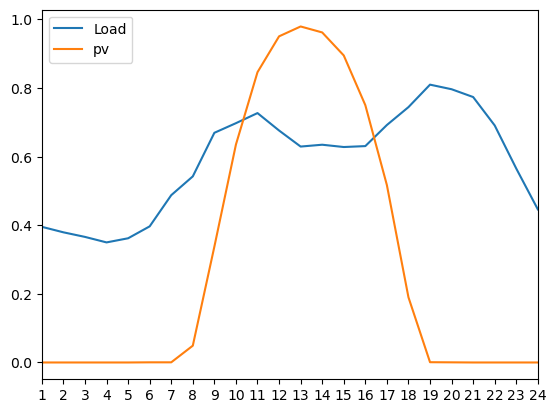

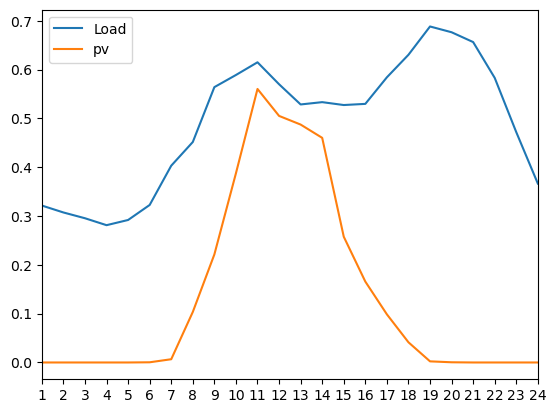

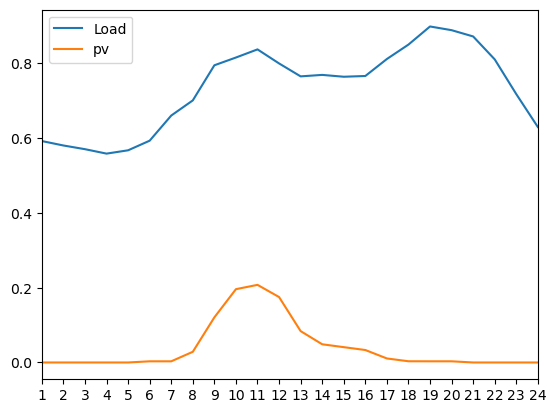

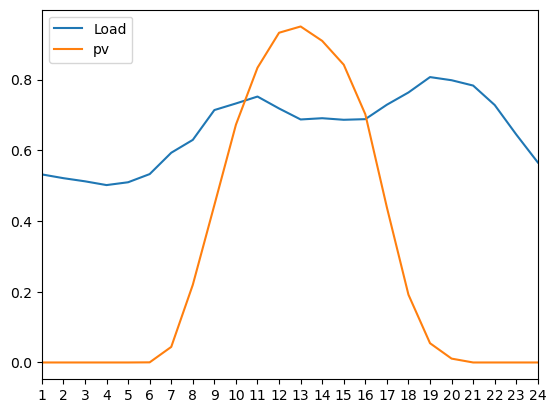

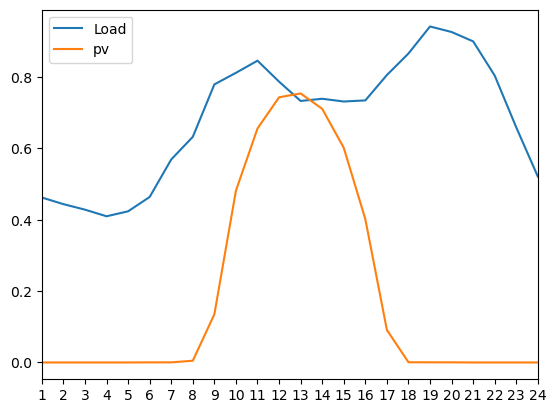

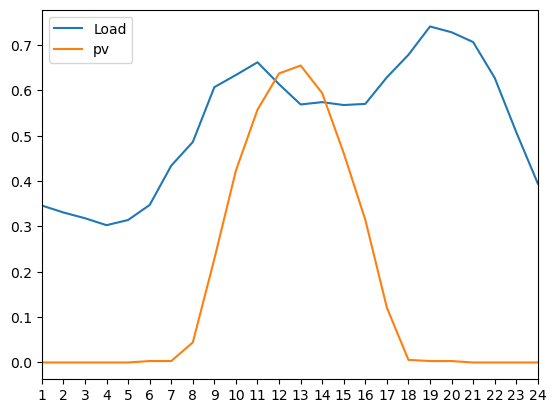

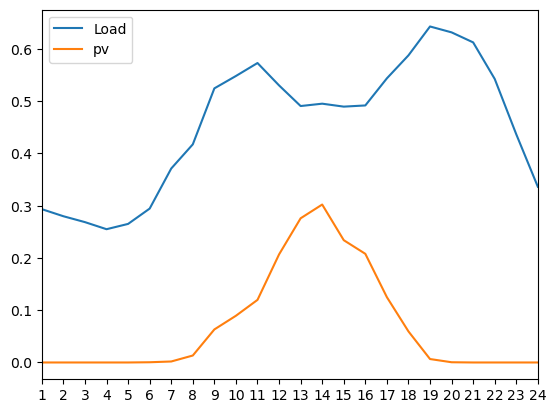

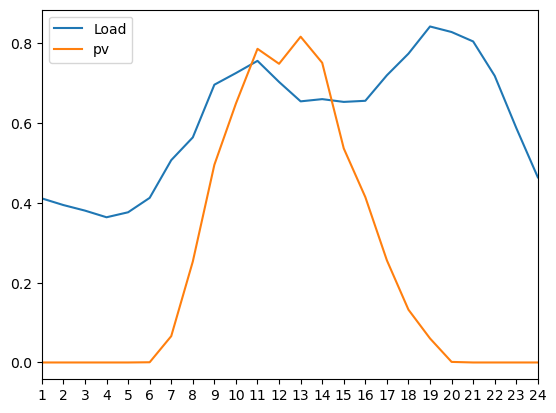

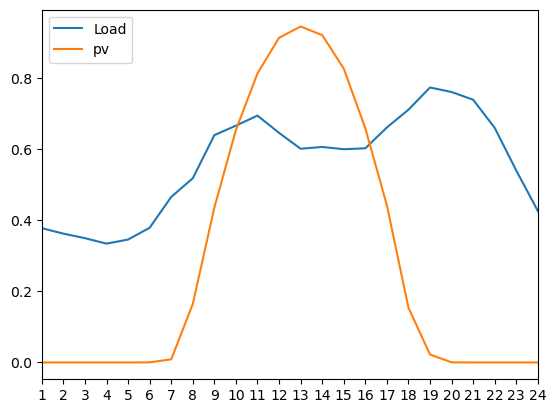

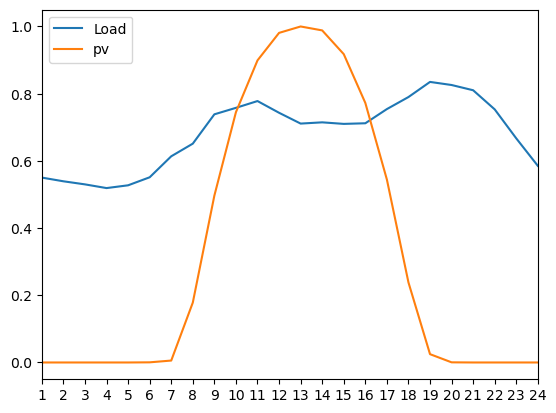

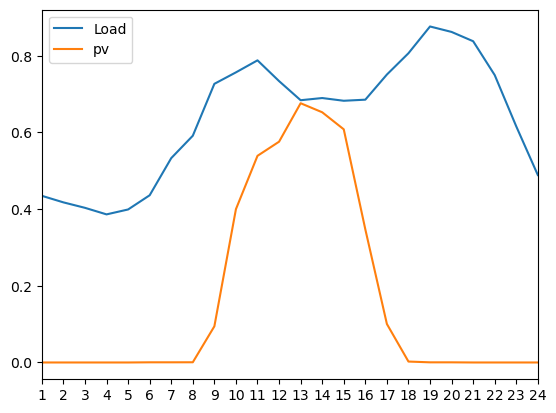

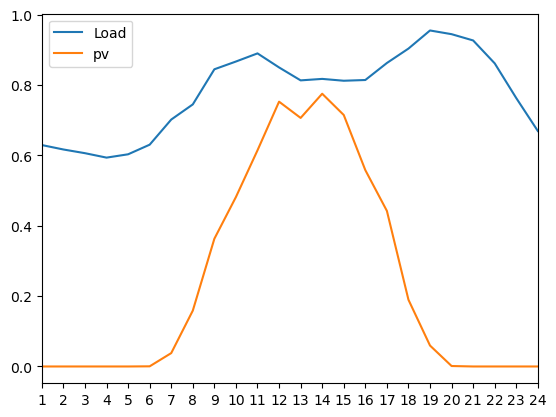

Set parameter Username
Academic license - for non-commercial use only - expires 2023-11-10
Set parameter TimeLimit to value 3000
first_step: 9612448.707044384
first_step cap [6.0, array([0.        , 2.65906516, 1.21545455, 0.        , 2.64683621]), array(2.), array(2.32841049), array(1037.51487876)]
first_step cost [7200000.0, 1066076.0482989997, 0.0, 717349.1504841321, 0.0, 200000.0, 14737.315026761487, 414286.1932345565]
freq_nadir: {0: array([[-0.75541399, -0.74198022, -0.73068948, -0.70398137, -0.72721474,
        -0.75653045, -0.75579534, -0.84073497, -0.8687147 , -0.85110147,
        -0.83438049, -0.864431  , -0.89763473, -0.89353733, -0.8986466 ,
        -0.89661677, -0.78122465, -0.58234381, -0.61184468, -0.61340276,
        -0.59582616, -0.55751988, -0.51151604, -0.59702615],
       [-0.64650775, -0.6629263 , -0.63738433, -0.60675122, -0.62972605,
        -0.64890081, -0.720091  , -0.80000111, -0.87970924, -0.89627146,
        -0.90933831, -0.88370808, -0.85594191, -0.85919189

In [18]:
start = time.time()
# df_load = pd.read_csv("data/day_load.csv", header=None)
# load = df_load.values
# cluster_load = cluster_net_load(10*load)
# cluster_load.get_cluster()
# print('cluster finished')
file_list = ["data/day_load.csv", "data/day_pv.csv",
             "data/cluster_day.csv", "data/period.csv"]
data = read_data(file_list)
day_load, day_pv, cluster_day_num, period = data.get_data()
# df_day_load = pd.read_csv("data/load_day_data_cluster4.csv", header=None)
# day_load = df_day_load.values
# df_day_pv = pd.read_csv("data/pv_day_data_cluster4.csv", header=None)
# day_pv = df_day_pv.values
# df_cluster_day_num = pd.read_csv("data/cluster_day.csv", header=None)
# cluster_day_num = df_cluster_day_num.values[1]
# df_period = pd.read_csv("data/period.csv", header=None)
# period = df_period.values
day_num = day_load.shape[0]
# show cluster
for day_index in range(day_num):
        load_hour = day_load[day_index]
        pv_hour = day_pv[day_index]
        fig, axe = plt.subplots()
        x = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
                 21, 22, 23, 24])
        labels = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12",
              "13", "14", "15", "16", "17", "18", "19", "20", "21", "22", "23", "24"]
        axe.plot(x, load_hour, label="Load")
        axe.plot(x, pv_hour, label="pv")
        plt.xlim((1, 24))
        axe.set_xticks(x)
        axe.set_xticklabels(labels)
        axe.legend(loc='upper left')
        plt.show()
# first step
first_step = first_step_planning(day_load, day_pv, cluster_day_num, period)
(cost, cap_com, cost_com, f_max, mask, H_inertia, D, SMR_droop, PV_droop, BESS_droop, fast_droop_expand,
cap_com_save, SMR_output_save, PV_output_save, PV_output_cut_save, BESS_charge_power_save, 
BESS_discharge_power_save, SESS_charge_power_save, SESS_discharge_power_save, cost_save, cost_com_save,
freq_nadir, SMR_droop_response, PV_droop_response, BESS_droop_response, SMR_inertia_response, 
PV_inertia_response, BESS_inertia_response, SMR_damping_response, branch_flow_save, bus_phi_save) = first_step.get_initial_result()
print('first_step:', cost)
print('first_step cap', cap_com)
print('first_step cost', cost_com)
print('freq_nadir:', freq_nadir)
freq_iteration_process = freq_iteration(day_load, day_pv, cluster_day_num, period, cost, cap_com, cost_com, f_max, mask, H_inertia, D, 
                 SMR_droop, PV_droop, BESS_droop, fast_droop_expand, cap_com_save, SMR_output_save, PV_output_save, 
                 PV_output_cut_save, BESS_charge_power_save, BESS_discharge_power_save, SESS_charge_power_save, 
                 SESS_discharge_power_save, cost_save, cost_com_save, freq_nadir, SMR_droop_response, PV_droop_response,
                 BESS_droop_response, SMR_inertia_response, PV_inertia_response, BESS_inertia_response, SMR_damping_response,branch_flow_save, bus_phi_save)
(cost, cap_com, cost_com, cap_com_save, SMR_output_save, PV_output_save, PV_output_cut_save, BESS_charge_power_save, BESS_discharge_power_save, 
SESS_charge_power_save, SESS_discharge_power_save, cost_save, cost_com_save, freq_nadir, SMR_droop_response, PV_droop_response, 
BESS_droop_response, SMR_inertia_response, PV_inertia_response, BESS_inertia_response, SMR_damping_response, branch_flow_save, bus_phi_save) = freq_iteration_process.get_freq_ite_result()
PV_plan = {}
PV_plan[0] = sum(cap_com[1])
print('overall cost:', cost)
print('cap_com:', cap_com)
print('cost_com:', cost_com)
cap_com_save_out = {}
SMR_output_save_out = {}
PV_output_save_out = {}
PV_output_cut_save_out = {}
BESS_charge_power_save_out = {}
BESS_discharge_power_save_out = {}
SESS_charge_power_save_out = {}
SESS_discharge_power_save_out = {}
cost_save_out = {}
cost_com_save_out = {}
freq_nadir_out = {}
SMR_droop_response_out = {}
PV_droop_response_out = {}
BESS_droop_response_out = {}
SMR_inertia_response_out = {}
PV_inertia_response_out = {}
BESS_inertia_response_out = {}
SMR_damping_response_out = {}
# save out0 variable
cap_com_save_out[0] = cap_com_save
SMR_output_save_out[0] = SMR_output_save
PV_output_save_out[0] = PV_output_save
PV_output_cut_save_out[0] = PV_output_cut_save
BESS_charge_power_save_out[0] = BESS_charge_power_save
BESS_discharge_power_save_out[0] = BESS_discharge_power_save
SESS_charge_power_save_out[0] = SESS_charge_power_save
SESS_discharge_power_save_out[0] = SESS_discharge_power_save
cost_save_out[0] = cost_save
cost_com_save_out[0] = cost_com_save
freq_nadir_out[0] = freq_nadir
SMR_droop_response_out[0] = SMR_droop_response
PV_droop_response_out[0] = PV_droop_response
BESS_droop_response_out[0] = BESS_droop_response
SMR_inertia_response_out[0] = SMR_inertia_response
PV_inertia_response_out[0] = PV_inertia_response
BESS_inertia_response_out[0] = BESS_inertia_response
SMR_damping_response_out[0] = SMR_damping_response
end = time.time()
print('Time used: ', end-start)

In [18]:
branch_flow_save_out = {}
bus_phi_save_out = {}
branch_flow_save_out[0] = branch_flow_save
bus_phi_save_out[0] = bus_phi_save

In [19]:
# 在这里对结果进行检查,是否满足直流潮流的条件
# 需要保存网络变量,包括网络潮流和相角,并对网络潮流和相角的合理性进行检查

In [21]:
# branch_flow_save_out[0]

In [22]:
branch_flow_save[0][0].shape

(24, 32)

In [23]:
# 找到每一条线路的最大潮流,用于设置线路上限的边界条件
day_num = 12
hour_num = 24
branch_num = 32
branch_max_day = np.zeros((day_num, branch_num))
branch_max = np.zeros(branch_num)
for day_index in range(day_num):
    branch_max_day[day_index] = np.max(branch_flow_save[0][day_index], axis=0)
branch_max = np.max(branch_max_day, axis=0)

In [24]:
branch_max

array([5.83066061, 5.        , 4.55580606, 4.44475758, 4.33370909,
       3.42049067, 3.24804218, 2.23885152, 2.        , 1.9147697 ,
       1.82953939, 3.        , 2.77755758, 2.56381028, 0.8574169 ,
       0.5712078 , 0.28499871, 1.15757576, 0.86818182, 0.57878788,
       0.28939394, 0.86818182, 0.57878788, 0.28939394, 2.28620909,
       2.        , 1.71379091, 1.4469697 , 1.15757576, 0.86818182,
       0.57878788, 0.28939394])

In [52]:
# 打印出力及潮流信息
SMR_output_save[0][0]

array([4.5       , 4.5       , 4.5       , 4.5       , 4.5       ,
       4.5       , 4.5       , 4.5       , 4.5       , 4.5       ,
       4.04718789, 3.69718789, 3.49718789, 3.49718789, 3.69718789,
       4.41188394, 4.49221785, 4.49221785, 4.27085666, 4.25330019,
       4.27863881, 4.37320597, 4.5       , 4.5       ])

In [55]:
PV_output_save[0][0]

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 4.17961085e-03, 8.82053355e-02, 1.64708657e+00,
        4.29266846e+00, 6.45492257e+00, 8.13595335e+00, 9.13702397e+00,
        9.39732986e+00, 9.21302532e+00, 8.27167710e+00, 6.58961992e+00,
        4.34142179e+00, 1.42063896e+00, 2.01401635e-01, 3.59213336e-03,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.0000

In [84]:
BESS_charge_power_save[0]

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 2.69854056e-01, 1.40632467e+00,
        1.91373057e+00, 1.67832602e+00, 1.00087780e+00, 7.91666667e-03,
        7.91666667e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.35700000e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.66666667e-03, 1.66666667e-03, 1.66666667e-03,
        1.02150319e+00, 1.60000000e+00, 1.60000000e+00, 1.60000000e+00,
        4.50486987e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.0000

In [85]:
BESS_discharge_power_save[0]

array([[1.740896  , 0.47246953, 0.        , 0.        , 0.        ,
        0.        , 0.07199466, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 1.20004319, 1.6       , 0.84078328,
        0.        , 0.        , 0.        , 0.        ],
       [1.40391791, 0.88301471, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 1.6       , 1.6       , 0.2235338 ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.36766476, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 1.19741519, 1.6       , 0.62531385,
        0.        , 0.        , 0.        , 0.        ],
       [1.794

In [86]:
SESS_charge_power_save[0]

array([[2.462096  , 1.34696953, 1.0022    , 1.1555    , 1.0405    ,
        0.71257961, 0.        , 0.96308657, 2.39516846, 4.28912257,
        4.96648719, 4.96648719, 4.96648719, 4.96648719, 4.96648719,
        4.96648719, 2.21102297, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 1.66241291,
        2.89893284, 3.59603329, 3.53625939, 2.86788761, 2.09336089,
        0.45646273, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.2147    , 0.3832    , 0.5237    , 0.6922    , 0.5658    ,
        0.20458827, 0.        , 0.26851182, 0.52096661, 2.14059686,
        2.95154611, 4.51900916, 4.96648719, 4.96648719, 3.98219178,
        1.51852837, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [3.182

In [87]:
SESS_discharge_power_save[0]

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 1.66654171, 2.5134244 ,
        3.11526119, 2.22869403, 0.9011    , 0.        ],
       [0.        , 0.38937335, 1.16279851, 1.0322    , 1.12988806,
        1.41054964, 1.82240895, 0.96785716, 0.11864759, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.26031191, 2.85001316, 4.51507062,
        4.54531343, 3.82585821, 2.79567164, 1.82033582],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 2.23827473, 3.74782909,
        4.09695522, 3.11022388, 1.63227612, 0.3191    ],
       [0.   

In [63]:
bus_phi_save[0][0][0]

array([ 0.        , -0.0052094 , -0.02872077, -0.04359208, -0.05840219,
       -0.08324404, -0.08903464, -0.10780662, -0.12334381, -0.13757837,
       -0.14134821, -0.14763006, -0.16056894, -0.1645868 , -0.16798722,
       -0.17134526, -0.17518141, -0.17625864, -0.00614781, -0.01262945,
       -0.01381362, -0.01486609, -0.03079646, -0.03343492, -0.03475415,
       -0.08611304, -0.08962867, -0.0987772 , -0.10457807, -0.10816489,
       -0.11234405, -0.11324181, -0.1137774 ])

In [65]:
day_load[0][0]*10/33

0.11450909090909091

In [67]:
SMR_output_save[0][0][0] + BESS_discharge_power_save[0][0][0] - SESS_charge_power_save[0][0][0]

3.7788000000000004

In [69]:
-0.0052094*70.34*10

-3.66429196

In [71]:
-0.0052094+(-0.02872077)

-0.03393017

In [72]:
-0.03393017*13.15*10

-4.461817355000001

In [83]:
SMR_output_save[0]

array([[4.5       , 4.5       , 4.5       , 4.5       , 4.5       ,
        4.5       , 4.5       , 4.5       , 4.5       , 4.5       ,
        4.04718789, 3.69718789, 3.49718789, 3.49718789, 3.69718789,
        4.41188394, 4.49221785, 4.49221785, 4.27085666, 4.25330019,
        4.27863881, 4.37320597, 4.5       , 4.5       ],
       [4.46118209, 4.47521194, 4.48690149, 4.5       , 4.49041194,
        4.46062907, 4.42855748, 4.5       , 4.5       , 4.5       ,
        4.5       , 4.5       , 4.5       , 4.5       , 4.5       ,
        4.5       , 4.5       , 4.47753017, 4.09755147, 4.05886751,
        4.09038657, 4.20284179, 4.31272836, 4.41676418],
       [4.5       , 4.5       , 4.5       , 4.5       , 4.5       ,
        4.5       , 4.5       , 4.5       , 4.5       , 4.5       ,
        4.5       , 4.5       , 4.5       , 4.5       , 4.5       ,
        4.5       , 4.5       , 4.5       , 4.19087159, 4.11818308,
        4.16324478, 4.27917612, 4.43682388, 4.5       ],
       [4.5  

In [81]:
PV_output_sum = np.zeros((4, 24))
for day_index in range(4):
    PV_output_sum[day_index] = np.sum(PV_output_save[0][day_index], axis=0)

In [82]:
PV_output_sum

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 4.17961085e-03, 8.82053355e-02, 1.64708657e+00,
        4.29266846e+00, 6.45492257e+00, 8.13595335e+00, 9.13702397e+00,
        9.39732986e+00, 9.21302532e+00, 8.27167710e+00, 6.58961992e+00,
        4.34142179e+00, 1.42063896e+00, 2.01401635e-01, 3.59213336e-03,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 3.72128872e-03, 2.89633578e-01, 1.47414284e+00,
        3.25335241e+00, 5.24167957e+00, 6.69359950e+00, 7.01869996e+00,
        7.63616257e+00, 7.58538761e+00, 6.76196089e+00, 5.14456273e+00,
        3.98898699e+00, 2.08245792e+00, 3.52435371e-01, 4.62806695e-03,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 3.98826958e-03, 3.86835242e-01, 1.5988

In [88]:
# 查看每个时刻的网络平衡情况
system_gen = SMR_output_save[0] + PV_output_sum + BESS_discharge_power_save[0] + SESS_discharge_power_save[0] - BESS_charge_power_save[0] - SESS_charge_power_save[0]

In [89]:
system_gen

array([[3.7788, 3.6255, 3.4978, 3.3445, 3.4595, 3.7916, 4.6602, 5.184 ,
        6.3975, 6.6658, 6.9468, 6.4614, 6.0143, 6.0654, 6.0015, 6.0271,
        6.6147, 7.1129, 7.7388, 7.6111, 7.3939, 6.6019, 5.4011, 4.2643],
       [5.8651, 5.7476, 5.6497, 5.5322, 5.6203, 5.8749, 6.5406, 6.942 ,
        7.872 , 8.0776, 8.293 , 7.921 , 7.5784, 7.6175, 7.5686, 7.5881,
        8.0385, 8.4203, 8.9   , 8.8021, 8.6357, 8.0287, 7.1084, 6.2371],
       [4.2853, 4.1168, 3.9763, 3.8078, 3.9342, 4.2994, 5.2545, 5.8303,
        7.1646, 7.4596, 7.7686, 7.2349, 6.7433, 6.7995, 6.7292, 6.7573,
        7.4034, 7.9512, 8.6394, 8.499 , 8.2602, 7.3894, 6.0691, 4.8191],
       [3.1121, 2.9686, 2.849 , 2.7054, 2.8131, 3.1241, 3.9376, 4.4281,
        5.5646, 5.8158, 6.079 , 5.6244, 5.2057, 5.2536, 5.1938, 5.2177,
        5.768 , 6.2346, 6.8208, 6.7011, 6.4978, 5.756 , 4.6315, 3.5668]])

In [91]:
day_load*10

array([[3.7788, 3.6255, 3.4978, 3.3445, 3.4595, 3.7916, 4.6602, 5.184 ,
        6.3975, 6.6658, 6.9468, 6.4614, 6.0143, 6.0654, 6.0015, 6.0271,
        6.6147, 7.1129, 7.7388, 7.6111, 7.3939, 6.6019, 5.4011, 4.2643],
       [5.8651, 5.7476, 5.6497, 5.5322, 5.6203, 5.8749, 6.5406, 6.942 ,
        7.872 , 8.0776, 8.293 , 7.921 , 7.5784, 7.6175, 7.5686, 7.5881,
        8.0385, 8.4203, 8.9   , 8.8021, 8.6357, 8.0287, 7.1084, 6.2371],
       [4.2853, 4.1168, 3.9763, 3.8078, 3.9342, 4.2994, 5.2545, 5.8303,
        7.1646, 7.4596, 7.7686, 7.2349, 6.7433, 6.7995, 6.7292, 6.7573,
        7.4034, 7.9512, 8.6394, 8.499 , 8.2602, 7.3894, 6.0691, 4.8191],
       [3.1121, 2.9686, 2.849 , 2.7054, 2.8131, 3.1241, 3.9376, 4.4281,
        5.5646, 5.8158, 6.079 , 5.6244, 5.2057, 5.2536, 5.1938, 5.2177,
        5.768 , 6.2346, 6.8208, 6.7011, 6.4978, 5.756 , 4.6315, 3.5668]])

In [92]:
system_gen - day_load*10

array([[ 4.44089210e-16, -8.88178420e-16, -4.44089210e-16,
         8.88178420e-16,  4.44089210e-16, -4.44089210e-16,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00, -8.88178420e-16,
        -1.77635684e-15,  8.88178420e-16, -1.77635684e-15,
         8.88178420e-16, -8.88178420e-16,  1.77635684e-15,
        -8.88178420e-16,  1.77635684e-15, -1.77635684e-15,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        -8.88178420e-16,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00, -1.77635684e-15,
         0.00000000e+00,  1.77635684e-15,  0.00000000e+00,
         8.88178420e-16,  8.88178420e-16,  8.88178420e-16,
         0.00000000e+00,  0.00000000e+00,  1.77635684e-15,
         0.00000000e+00, -7.10542736e-15,  1.77635684e-15,
         0.00000000e+00,  8.88178420e-16,  0.00000000e+00],
       [-8.88178420e-16,  0.00000000e+00,  4.44089210e

In [104]:
import pickle
# open a file to save the dictionary
with open('result/cap_com_save_out_cluster8.pickle', 'wb') as handle:
    pickle.dump(cap_com_save_out, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('result/cap_com_save_out_cluster8.pickle', 'rb') as handle:
    my_test = pickle.load(handle)

In [105]:
import pickle
# open a file to save the dictionary
with open('result/cost_com_save_out_cluster8.pickle', 'wb') as handle:
    pickle.dump(cost_com_save_out, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('result/cost_com_save_out_cluster8.pickle', 'rb') as handle:
    my_test = pickle.load(handle)

In [123]:
power_balance = {}
power_balance[0] = SMR_output_save_out[6][3]
power_balance[1] = PV_output_save_out[6][3]
power_balance[2] = BESS_charge_power_save_out[6][3]
power_balance[3] = BESS_discharge_power_save_out[6][3]
power_balance[4] = SESS_charge_power_save_out[6][3]
power_balance[5] = SESS_discharge_power_save_out[6][3]
# power_balance[6] = 10*day_load
import pickle
# open a file to save the dictionary
with open('result/power_balance_cluster8.pickle', 'wb') as handle:
    pickle.dump(power_balance, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('result/power_balance_cluster8.pickle', 'rb') as handle:
    my_test = pickle.load(handle)

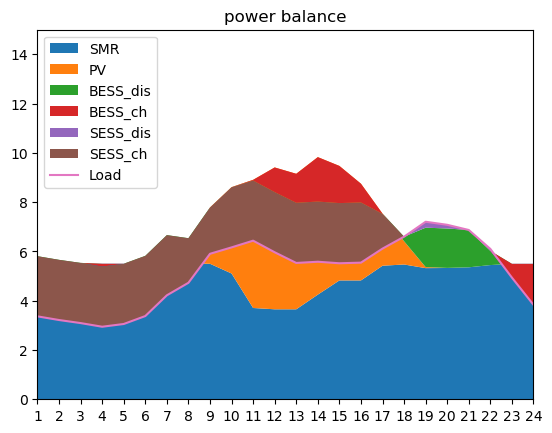

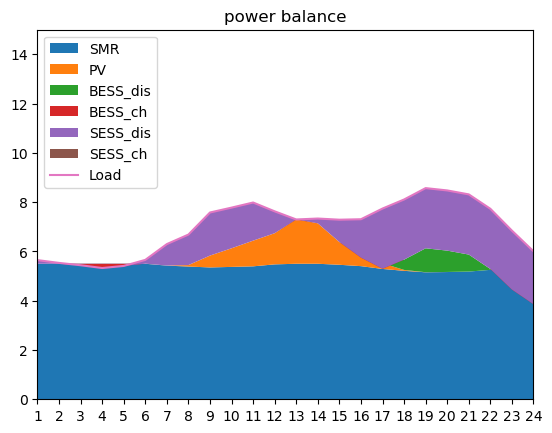

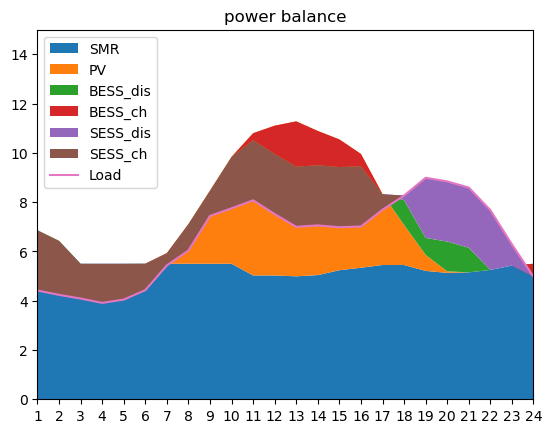

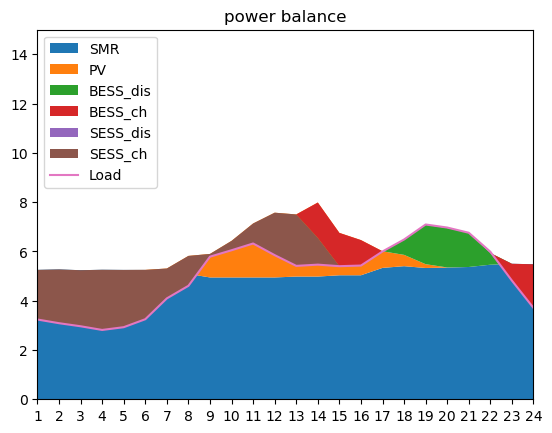

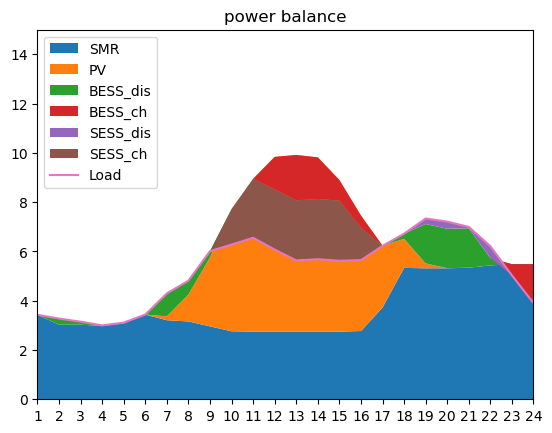

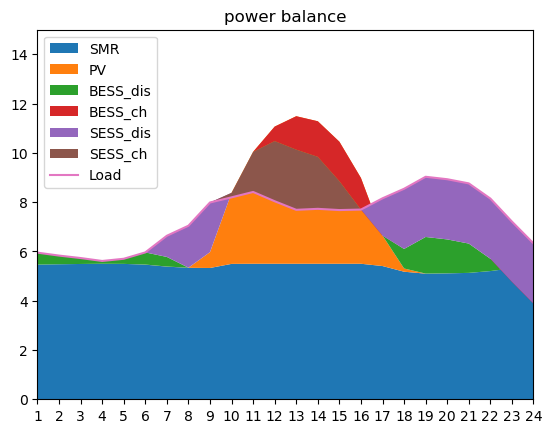

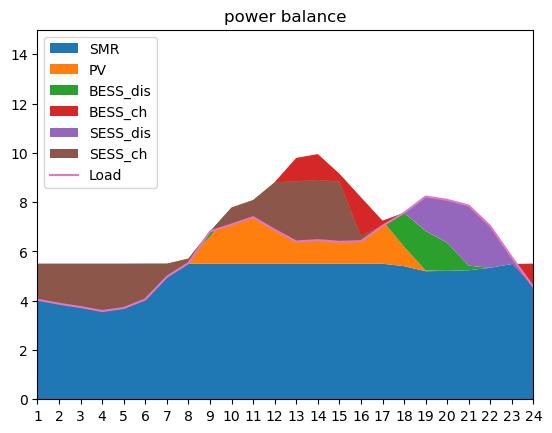

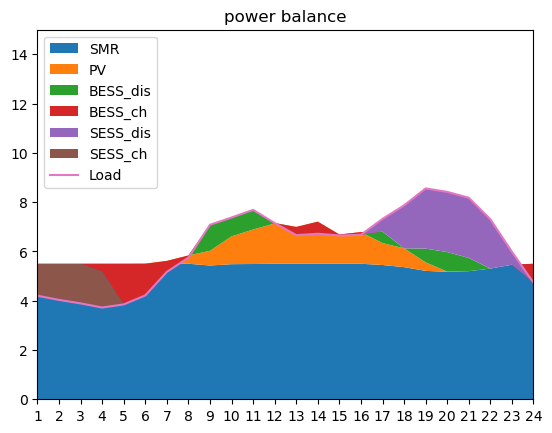

In [121]:
# show power balance result for each representative day
for day_index in range(day_num):
    SMR_p = SMR_output_save_out[6][3][day_index]
    PV_p = PV_output_save_out[6][3][day_index]
    BESS_pc = BESS_charge_power_save_out[6][3][day_index]
    BESS_pd = BESS_discharge_power_save_out[6][3][day_index]
    SESS_pc = SESS_charge_power_save_out[6][3][day_index]
    SESS_pd = SESS_discharge_power_save_out[6][3][day_index]
    # print('power:',SMR_p+PV_p+BESS_pd+SESS_pd)
    load_hour = SMR_p + PV_p + BESS_pd - BESS_pc + SESS_pd - SESS_pc;
    # print('out:',BESS_pc+SESS_pc+load_hour)
    y_SMR = SMR_p
    y_PV = PV_p
    y_BESS_pc = BESS_pc
    y_BESS_pd = BESS_pd
    y_SESS_pc = SESS_pc
    y_SESS_pd = SESS_pd
    fig, axe = plt.subplots()
    x = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
                 21, 22, 23, 24])
    labels = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12",
              "13", "14", "15", "16", "17", "18", "19", "20", "21", "22", "23", "24"]
    axe.stackplot(x, y_SMR, y_PV, y_BESS_pd, -y_BESS_pc, y_SESS_pd, -y_SESS_pc,
                  labels=["SMR", "PV", "BESS_dis", "BESS_ch", "SESS_dis", "SESS_ch"])
    axe.plot(x, load_hour, label="Load")
    plt.xlim((1, 24))
    plt.ylim((0, 15))
    axe.set_xticks(x)
    axe.set_xticklabels(labels)
    axe.set_title("power balance")
    axe.legend(loc='upper left')
    plt.show()

In [108]:
import pickle
# open a file to save the dictionary
with open('result/cap_com_save_out_variable_reserve_cluster8.pickle', 'wb') as handle:
    pickle.dump(cap_com_save_out, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('result/cap_com_save_out_variable_reserve_cluster8.pickle', 'rb') as handle:
    my_test = pickle.load(handle)

In [109]:
import pickle
# open a file to save the dictionary
with open('result/cost_com_save_out_variable_reserve_cluster8.pickle', 'wb') as handle:
    pickle.dump(cost_com_save_out, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('result/cost_com_save_out_variable_reserve_cluster8.pickle', 'rb') as handle:
    my_test = pickle.load(handle)

In [110]:
import pickle
# open a file to save the dictionary
with open('result/freq_ite_final_variable_reserve_cluster8.pickle', 'wb') as handle:
    pickle.dump(freq_nadir, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('result/freq_ite_final_variable_reserve_cluster8.pickle', 'rb') as handle:
    my_test = pickle.load(handle)

In [112]:
freq_response = {}
freq_response[0] = 2*4.5*55/50
freq_response[1] = 0.6*55/50
freq_response[2] = SMR_droop
freq_response[3] = PV_droop
freq_response[4] = BESS_droop
freq_response[5] = 0.05*10*day_load
import pickle
# open a file to save the dictionary
with open('result/freq_response_variable_reserve_cluster8.pickle', 'wb') as handle:
    pickle.dump(freq_response, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('result/freq_response_variable_reserve_cluster8.pickle', 'rb') as handle:
    my_test = pickle.load(handle)

In [113]:
my_test

{0: 9.9,
 1: 0.66,
 2: array([[0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.5625    , 0.58104244, 0.58104244, 0.64354244, 0.64354244,
         0.58104244, 0.08343796, 0.20843796, 0.39593796, 0.37597824,
         0.34237313, 0.21737313, 0.02747761, 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.03086381, 0.17237723, 0.04591734,
         0.05047556, 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.17667964, 0.31565382, 0.51511036, 0.51509146,
         0.47813433, 0.33865672, 0.12720896, 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.11408933, 0.36848353, 0.40950883,
         0.41440299, 0.28165672, 0

In [19]:
import numpy as np

# 生成33个随机的大于0.015的正数
random_numbers = np.random.rand(33) * 0.985 + 0.015

# 将这些数字归一化，使它们的总和为1
normalized_numbers = random_numbers / np.sum(random_numbers)

# 输出生成的33个数字
print(normalized_numbers)

[0.05459535 0.04850083 0.04602033 0.0033047  0.01280769 0.05426434
 0.01452    0.05537609 0.0326172  0.0316186  0.02476146 0.00444691
 0.03479117 0.0194887  0.04319882 0.057237   0.00366073 0.0329127
 0.0046264  0.02038603 0.00665962 0.0456034  0.03605606 0.02388347
 0.01496024 0.02898188 0.04053858 0.01260634 0.01724058 0.05632622
 0.06068536 0.05081117 0.00651201]
